# Practical performance analysis

Machine learning tasks are usually part of the larger process and thus you often need to know the answers for following questions:

* Does adding more data increase performance?
* How much data is needed to increase performance by one precent point?
* Does adding more data reduce overfitting?
* How much data is needed to increase model stability by one precent point?

A machine learning task is data bound if adding more data has bigger inpact on the performance than prolonging training procedure or using more elaborate models for prediction. 
Only if performance is saturated and it does not change with the amount of training data, an extensive search for new models and training methods is justified.

A model overfits the data if two models trained on the different training sets provide different predictions. We can quantify statistical stability of a model by computing Cohen’s Kappa score for models trained on different training sets. This is usually a theoretical measure as we cannot afford to sample to independent training sets -- it is much more reasonable to combine them into a single training set.     

In the following we use the MNIST dataset to explore these consepts by comparing different neural network architectures. Consult materials for training neural networks in Tensorflow and Keras for further details:

* [Tensorflow tutorials](https://www.tensorflow.org/tutorials)
* [Deep Learning with TensorFlow 2 and Keras - Second Edition](https://www.packtpub.com/product/deep-learning-with-tensorflow-2-and-keras-second-edition/9781838823412)


## I.  The MNIST dataset of handwritten digits

This dataset contains 60,000 training samples and 10,000 test samples. 
This allows us to visualise concapts that are capture in smaller datasets.  

In [67]:
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

In [68]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(f'Shape of training data:   {x_train.shape}')
print(f'Shape of training labels: {y_train.shape}')
print(f'Shape of test data:       {x_test.shape}')
print(f'Shape of test labels:     {y_test.shape}')

Shape of training data:   (60000, 28, 28)
Shape of training labels: (60000,)
Shape of test data:       (10000, 28, 28)
Shape of test labels:     (10000,)


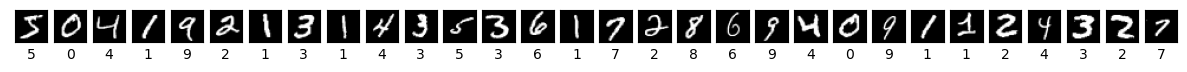

In [3]:
plt.figure(figsize=(15,5), dpi=100)
for i in range(30):
    plt.subplot(1,30,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i,:,:], cmap = 'gray')
    plt.xlabel(y_train[i])
plt.show()

## II.  Analysis of perceptron model  

In [4]:
from tqdm.notebook import tqdm
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical

import numpy as np
from pandas import DataFrame
from pandas import read_csv
from pandas import concat 
from pandas import Categorical
from plotnine import *

### Model

Let us define perceptron model and fix initail weights. 
In the following we are going to train many different models from scratch.
The easiest way to achieve this is to reset the model each time we start training.
Otherwise, the model still remembers previous data and just continues learning.

In [13]:
percepton = models.Sequential(name = 'Perceptron')
percepton.add(layers.Flatten(
    name='reshape', input_shape=(28,28)))
percepton.add(layers.Dense(
    name='softmax', 
    units=10, input_shape= (28*28,), 
    kernel_initializer='random_normal', activation='softmax'))
percepton.summary()

percepton.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

percepton.save_weights('percepton.hdf5', save_format='h5')

Model: "Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Flatten)           (None, 784)               0         
                                                                 
 softmax (Dense)             (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


### Testset

We need a test set on which we evaluate the performance of different models. For techincal reasons we need to use one-hot-encoding for lables.

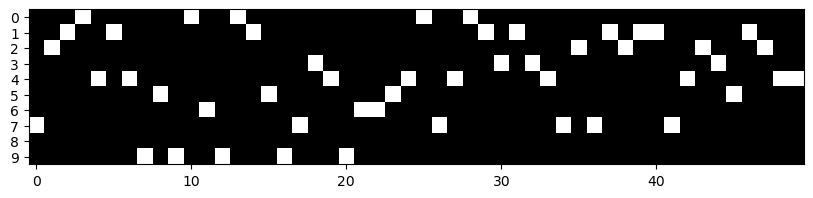

In [5]:
test_images = x_test
test_labels = to_categorical(y_test)

plt.figure(figsize=(10, 5), dpi=100)
plt.imshow(test_labels[:50].T,cmap='gray') 
plt.yticks(range(10))
plt.show()

### Dataset size vs performance

For simplicity we consider only the accuracy as the performance measure but the methodology applies for any other measure.

In [164]:
n = x_train.shape[0]
sizes = [round(0.01 * n * k) for k in range(1,10)] + [round(0.1 * n * k) for k in range(1,10)] + [n]
df = (DataFrame({'size': sizes})
      .assign(train_accuracy=np.nan)
      .assign(test_accuracy=np.nan)
      .set_index('size'))

In [29]:
for size in tqdm(sizes):
    train_images = x_train[:size, :, :]
    train_labels = to_categorical(y_train[:size])
    percepton.load_weights('percepton.hdf5')    
    percepton.fit(train_images, train_labels, epochs=5, batch_size=64, verbose=0)
    df.loc[size, 'train_accuracy'] = percepton.evaluate(train_images, train_labels, verbose=0)[1]
    df.loc[size, 'test_accuracy']  = percepton.evaluate(test_images,  test_labels,  verbose=0)[1]

df.to_csv('percepton_performance.csv', index = True)
display(df.head())

  0%|          | 0/19 [00:00<?, ?it/s]

,train_accuracy,test_accuracy
size,,
600,0.803333,0.6469
1200,0.829167,0.7233
1800,0.851111,0.7646
2400,0.847917,0.7882
3000,0.898000,0.8300
3600,0.865000,0.8051
4200,0.871429,0.8214
4800,0.903958,0.8518
5400,0.912407,0.8531


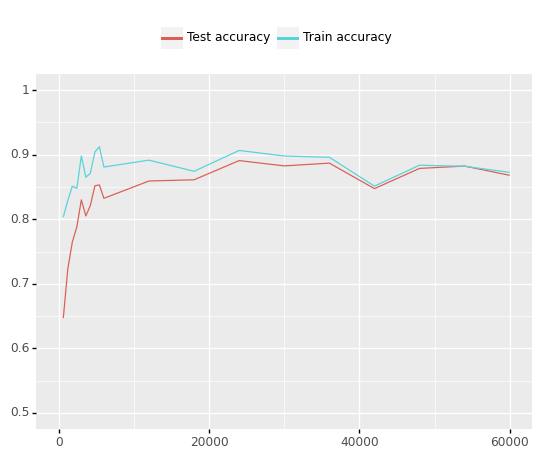

<ggplot: (385064903)>

In [8]:
df = read_csv('percepton_performance.csv')
sdf = df.melt(id_vars=['size'], var_name = 'measure', value_name = 'accuracy')
sdf['measure'] = sdf['measure'].str.capitalize().str.replace('_', ' ')

p = ggplot(sdf) 
p = p + geom_line(aes(x='size', y='accuracy', color='measure'))
p = p + ylim(0.5, 1) + xlim(0, 60000)
p = p + xlab('') + ylab('')
p = p + theme(subplots_adjust={'top': 0.85})
p = p + theme(legend_position=(.5, .925), legend_direction='horizontal', legend_title=element_blank())

p.save('perceptron_performance.pdf', width=10, height=10, units='cm', verbose=False)
display(p)

## III.  Analysis of eight layer convolutional neural network 

In [6]:
conv_network = models.Sequential()
conv_network.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
conv_network.add(layers.MaxPooling2D((2, 2)))
conv_network.add(layers.Conv2D(64, (3, 3), activation='relu'))
conv_network.add(layers.MaxPooling2D((2, 2)))
conv_network.add(layers.Conv2D(64, (3, 3), activation='relu'))
conv_network.add(layers.Flatten())
conv_network.add(layers.Dense(64, activation='relu'))
conv_network.add(layers.Dense(10, activation='softmax'))
conv_network.summary()

conv_network.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

conv_network.save_weights('conv_network.hdf5', save_format='h5')

Metal device set to: Apple M1 Max
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)    

2022-02-15 00:55:36.446066: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-15 00:55:36.446335: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Dataset size vs performance

In [10]:
n = x_train.shape[0]
sizes = [round(0.01 * n * k) for k in range(1,10)] + [round(0.1 * n * k) for k in range(1,10)] + [n]
df = (DataFrame({'size': sizes})
      .assign(train_accuracy=np.nan)
      .assign(test_accuracy=np.nan)
      .set_index('size'))

In [90]:
for size in tqdm(sizes):
    train_images = x_train[:size, :, :]
    train_labels = to_categorical(y_train[:size])
    conv_network.load_weights('conv_network.hdf5')    
    conv_network.fit(train_images, train_labels, epochs=5, batch_size=64, verbose=0)
    df.loc[size, 'train_accuracy'] = conv_network.evaluate(train_images, train_labels, verbose=0)[1]
    df.loc[size, 'test_accuracy']  = conv_network.evaluate(test_images,  test_labels,  verbose=0)[1]

df.to_csv('conv_network_performance.csv', index = True)
display(df.head())    

  0%|          | 0/19 [00:00<?, ?it/s]

,train_accuracy,test_accuracy
size,,
600,0.766667,0.6133
1200,0.983333,0.8981
1800,0.877778,0.8267
2400,0.977083,0.9291
3000,0.983667,0.9428


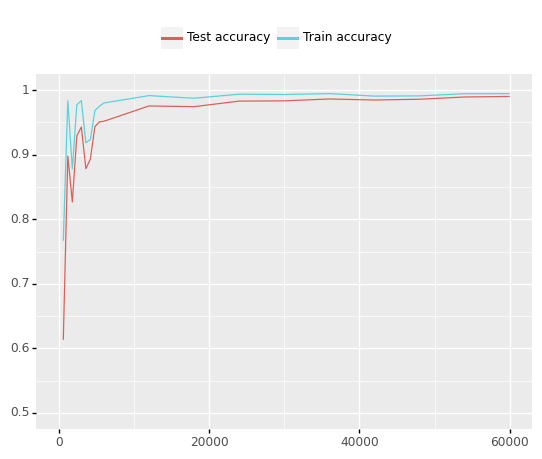

<ggplot: (698231275)>

In [11]:
df = read_csv('conv_network_performance.csv')
sdf = df.melt(id_vars=['size'], var_name = 'measure', value_name = 'accuracy')
sdf['measure'] = sdf['measure'].str.capitalize().str.replace('_', ' ')

p = ggplot(sdf) 
p = p + geom_line(aes(x='size', y='accuracy', color='measure'))
p = p + ylim(0.5, 1) + xlim(0, 60000)
p = p + xlab('') + ylab('')
p = p + theme(subplots_adjust={'top': 0.85})
p = p + theme(legend_position=(.5, .925), legend_direction='horizontal', legend_title=element_blank())

p.save('conv_network_performance.pdf', width=10, height=10, units='cm', verbose=False)
display(p)

### Quick comparison with perceptron

In [29]:
sdf = (
    concat([
        read_csv('percepton_performance.csv').assign(model='Perceptron'),
        read_csv('conv_network_performance.csv').assign(model='Convolutional network')], 
        axis=0)
    .melt(id_vars=['size', 'model'], var_name = 'measure', value_name = 'accuracy')
    .assign(measure = lambda df: df['measure'].str.capitalize().str.replace('_', ' '))
    .assign(model = lambda df: Categorical(df['model'],['Perceptron', 'Convolutional network']))
)

/Users/swen/Library/miniforge3/envs/machine-learning/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/swen/Library/miniforge3/envs/machine-learning/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/swen/Library/miniforge3/envs/machine-learning/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/swen/Library/miniforge3/envs/machine-learning/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


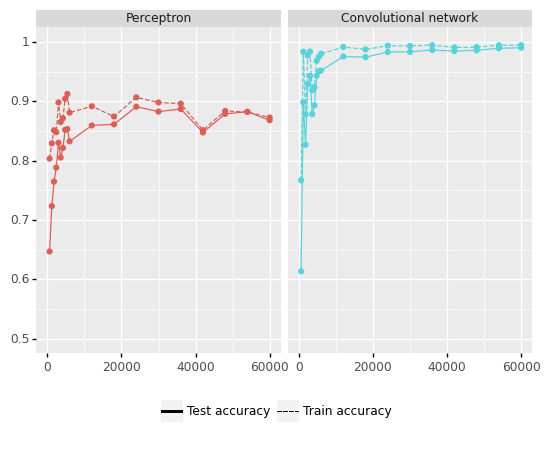

<ggplot: (740775756)>

In [30]:
p = ggplot(sdf)
p = p + geom_point(aes(x='size', y='accuracy', color='model'))
p = p + geom_line(aes(x='size', y='accuracy', color='model', linetype='measure'))
p = p + ylim(0.5, 1) + xlim(0, 60000)
p = p + xlab('') + ylab('')
p = p + theme(subplots_adjust={'bottom': 0.20})
p = p + theme(legend_position=(.5, .08), legend_direction='horizontal', legend_title=element_blank())
p = p + facet_wrap('model')
p = p + scale_color_discrete(guide=False)
p.save('perceptron_vs_conv_network_performance.pdf', width=17, height=10, units='cm', verbose=False)
display(p)


## IV. Uncertainty in the test error

Test error depends obviously on the test data. 
However, if the test set is independently sampled and large enough then the test error is roughly the same for each test set. 
However, there is still some variability left.
In the following, we study this issue further by splitting the test set into 10 different subsets and by visualising the corresponding variance.     

In [7]:
from pandas import MultiIndex

In [8]:
m = x_test.shape[0]
test_splits = [round(0.1 * m * k) for k in range(10)] 
df = (DataFrame(index=MultiIndex.from_product([sizes,range(10)], names = ['size', 'fold']))
      .assign(test_accuracy=np.nan))

NameError: name 'sizes' is not defined

In [232]:
for size in tqdm(sizes):
    train_images = x_train[:size, :, :]
    train_labels = to_categorical(y_train[:size])
    percepton.load_weights('percepton.hdf5')    
    percepton.fit(train_images, train_labels, epochs=5, batch_size=64, verbose=0)
    
    for fold, (start, end) in enumerate(zip(sizes, test_splits[1:] + [m])):
        df.loc[(size, fold), 'test_accuracy' ] = percepton.evaluate(
            test_images[start:end, :, :], test_labels[start:end], verbose=0)[1]    

df.to_csv('perceptron_performance_over_folds.csv', index = True)
display(df.head())  

  0%|          | 0/19 [00:00<?, ?it/s]

test_accuracy
size fold               
600  0          0.587500
     1          0.567500
     2          0.580833
     3          0.576250
     4          0.580000

In [20]:
m = x_test.shape[0]
test_splits = [round(0.1 * m * k) for k in range(10)] 
df = (DataFrame(index=MultiIndex.from_product([sizes,range(10)], names = ['size', 'fold']))
      .assign(test_accuracy=np.nan))

In [22]:
for size in tqdm(sizes):
    train_images = x_train[:size, :, :]
    train_labels = to_categorical(y_train[:size])
    conv_network.load_weights('conv_network.hdf5')    
    conv_network.fit(train_images, train_labels, epochs=5, batch_size=64, verbose=0)
    
    for fold, (start, end) in enumerate(zip(sizes, test_splits[1:] + [m])):
        df.loc[(size, fold), 'test_accuracy' ] = conv_network.evaluate(
            test_images[start:end, :, :], test_labels[start:end], verbose=0)[1]    

df.to_csv('conv_network_performance_over_folds.csv', index = True)
display(df.head())

  0%|          | 0/19 [00:00<?, ?it/s]

2022-02-14 23:11:43.936753: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-14 23:11:44.136436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-14 23:11:45.063308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-14 23:11:45.233420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-14 23:12:28.406262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


test_accuracy
size fold               
600  0          0.662500
     1          0.640000
     2          0.643333
     3          0.648125
     4          0.644000

/Users/swen/Library/miniforge3/envs/machine-learning/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/swen/Library/miniforge3/envs/machine-learning/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/swen/Library/miniforge3/envs/machine-learning/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_jitter : Removed 8 rows containing missing values.
/Users/swen/Library/miniforge3/envs/machine-learning/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/swen/Library/miniforge3/envs/machine-learning/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWa

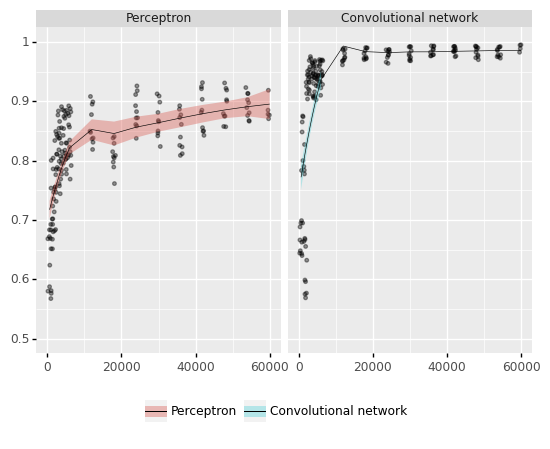

<ggplot: (701092584)>

In [70]:
sdf = (
    concat([
        read_csv('perceptron_performance_over_folds.csv').assign(model='Perceptron'),
        read_csv('conv_network_performance_over_folds.csv').assign(model='Convolutional network')], 
        axis=0)
    .melt(id_vars=['size', 'fold', 'model'], var_name = 'measure', value_name = 'accuracy')
    .assign(measure = lambda df: df['measure'].str.capitalize().str.replace('_', ' '))
    .assign(model = lambda df: Categorical(df['model'],['Perceptron', 'Convolutional network']))
)

p = ggplot(sdf) 
p = p + geom_jitter(aes(x='size', y='accuracy', group='size'), width=500, shape='o', size=1.0, alpha=0.4, fill='black', color='black')
p = p + geom_smooth(aes(x='size', y='accuracy', fill='model'), se=True, size=0.25)
p = p + ylim(0.5, 1) + xlim(0, 60000)
p = p + xlab('') + ylab('')
p = p + facet_wrap('model')
p = p + theme(subplots_adjust={'bottom': 0.20})
p = p + theme(legend_position=(.5, .08), legend_direction='horizontal', legend_title=element_blank())
p = p + facet_wrap('model')
p = p + scale_color_discrete(guide=False)
p.save('perceptron_vs_conv_network_performanceover_folds.pdf', width=17, height=10, units='cm', verbose=False)
display(p)

## V. Statistical stability

One way to characterise overfitting and statistical stability is to ask:
* How different are predictions if they are trained on independent training sets?

For that we can randomly split the training set into two halves and compare the predictions trained on different models. 
For exact quantification we use Cohen’s Kappa coefficient as it has clearly interpretable meaning.    


In [16]:
from numpy.random import choice
from sklearn.metrics import cohen_kappa_score

In [10]:
n = x_train.shape[0]
samples_1 = choice(list(range(n)), round(n/2), replace=False)
samples_2 = list(set(range(n)) - set(samples_1)) 
samples_2 = choice(samples_2, len(samples_2), replace=False)

In [38]:
sizes = [round(0.01 * n * k) for k in range(1,10)] + [round(0.1 * n * k) for k in range(1,5)] + [len(samples_1)]
df = (DataFrame({'size': sizes})
      .assign(cohen_kappa=np.nan)
      .assign(match=np.nan)
      .set_index('size'))

In [39]:
for size in tqdm(sizes):
    idx = samples_1[:size]
    train_images = x_train[idx, :, :]
    train_labels = to_categorical(y_train[idx])
    percepton.load_weights('percepton.hdf5')    
    percepton.fit(train_images, train_labels, epochs=5, batch_size=64, verbose=0)
    prediction_1 = np.argmax(percepton.predict(test_images), axis=1)
    
    idx = samples_2[:size]
    train_images = x_train[idx, :, :]
    train_labels = to_categorical(y_train[idx])
    percepton.load_weights('percepton.hdf5')    
    percepton.fit(train_images, train_labels, epochs=5, batch_size=64, verbose=0)
    prediction_2 = np.argmax(percepton.predict(test_images), axis=1)
    
    df.loc[size, 'cohen_kappa'] = cohen_kappa_score(prediction_1, prediction_2)
    df.loc[size, 'match'] = np.mean(prediction_1 == prediction_2)

df.to_csv('percepton_statistical_stability.csv', index=True)
display(df.head())

  0%|          | 0/14 [00:00<?, ?it/s]

,cohen_kappa,match
size,,
600,0.620805,0.6548
1200,0.790051,0.8113
1800,0.847175,0.8629
2400,0.800433,0.8206
3000,0.846319,0.8618


In [ ]:
df = (DataFrame({'size': sizes})
      .assign(cohen_kappa=np.nan)
      .set_index('size'))

In [40]:
for size in tqdm(sizes):
    idx = samples_1[:size]
    train_images = x_train[idx, :, :]
    train_labels = to_categorical(y_train[idx])
    conv_network.load_weights('conv_network.hdf5')    
    conv_network.fit(train_images, train_labels, epochs=5, batch_size=64, verbose=0)
    prediction_1 = np.argmax(conv_network.predict(test_images), axis=1)
    
    idx = samples_2[:size]
    train_images = x_train[idx, :, :]
    train_labels = to_categorical(y_train[idx])
    conv_network.load_weights('conv_network.hdf5')    
    conv_network.fit(train_images, train_labels, epochs=5, batch_size=64, verbose=0)
    prediction_2 = np.argmax(conv_network.predict(test_images), axis=1)
    
    df.loc[size, 'cohen_kappa'] = cohen_kappa_score(prediction_1, prediction_2)
    df.loc[size, 'match'] = np.mean(prediction_1 == prediction_2)

df.to_csv('conv_network_statistical_stability.csv', index=True)
display(df.head())

  0%|          | 0/14 [00:00<?, ?it/s]

2022-02-15 01:13:58.218872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-15 01:13:59.095401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-15 01:14:38.233760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


,cohen_kappa,match
size,,
600,0.676498,0.7092
1200,0.853802,0.8685
1800,0.729947,0.7579
2400,0.850689,0.8655
3000,0.932519,0.9393


In [41]:
sdf = (
    concat([
        read_csv('percepton_statistical_stability.csv').assign(model='Perceptron'),
        read_csv('conv_network_statistical_stability.csv').assign(model='Convolutional network')], 
        axis=0)
    .assign(model = lambda df: Categorical(df['model'],['Perceptron', 'Convolutional network']))
)

/Users/swen/Library/miniforge3/envs/machine-learning/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/swen/Library/miniforge3/envs/machine-learning/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/swen/Library/miniforge3/envs/machine-learning/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/swen/Library/miniforge3/envs/machine-learning/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


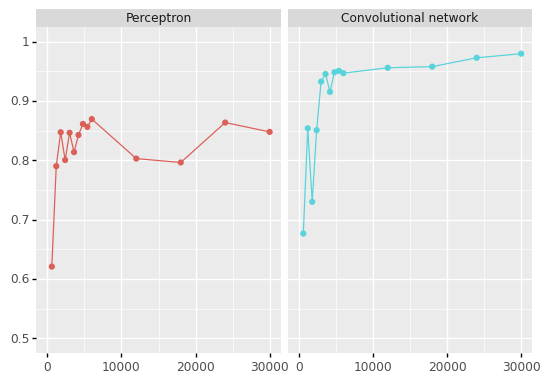

<ggplot: (763245490)>

/Users/swen/Library/miniforge3/envs/machine-learning/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/swen/Library/miniforge3/envs/machine-learning/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/swen/Library/miniforge3/envs/machine-learning/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/swen/Library/miniforge3/envs/machine-learning/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


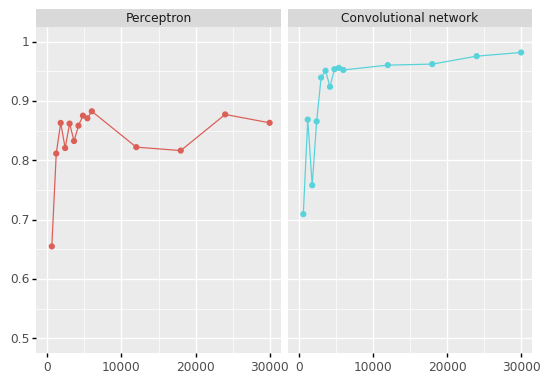

<ggplot: (763459335)>

In [43]:
p = ggplot(sdf) + geom_point(aes(x='size', y='cohen_kappa', color='model'))
p = p + geom_line(aes(x='size', y='cohen_kappa', color='model'))
p = p + ylim(0.5, 1) + xlim(0, 30000)
p = p + xlab('') + ylab('')
p = p + theme(subplots_adjust={'bottom': 0.20})
p = p + theme(legend_position=(.5, .08), legend_direction='horizontal', legend_title=element_blank())
p = p + facet_wrap('model')
p = p + scale_color_discrete(guide=False)
p.save('perceptron_vs_conv_network_stability_kappa.pdf', width=17, height=10, units='cm', verbose=False)
display(p)

p = ggplot(sdf) + geom_point(aes(x='size', y='match', color='model'))
p = p + geom_line(aes(x='size', y='match', color='model'))
p = p + ylim(0.5, 1) + xlim(0, 30000)
p = p + xlab('') + ylab('')
p = p + theme(subplots_adjust={'bottom': 0.20})
p = p + theme(legend_position=(.5, .08), legend_direction='horizontal', legend_title=element_blank())
p = p + facet_wrap('model')
p = p + scale_color_discrete(guide=False)
p.save('perceptron_vs_conv_network_stability_match.pdf', width=17, height=10, units='cm', verbose=False)
display(p)

## VI. Absolute vs relative performance

In most cases the test set is small and thus the test error can fluctuate so much that we cannot detect whether one model is better than the other.
Then there is clever trick to compare relative performance of different models. 
This measures the difference between model performance measures an is much more precise than the difference of absolute errors provided that we have large number of unlabelled data.
On flip side, it requires manual evaluation of unseen data samples and thus cannot be automated. 

In [45]:
size = 12000
train_images = x_train[:size, :, :]
train_labels = to_categorical(y_train[:size])
percepton.load_weights('percepton.hdf5')    
percepton.fit(train_images, train_labels, epochs=5, batch_size=64, verbose=0)
prediction_1 = np.argmax(percepton.predict(test_images), axis=1)

In [47]:
size = 60000
train_images = x_train[:size, :, :]
train_labels = to_categorical(y_train[:size])
percepton.load_weights('percepton.hdf5')    
percepton.fit(train_images, train_labels, epochs=5, batch_size=64, verbose=0)
prediction_2 = np.argmax(percepton.predict(test_images), axis=1)

### Maximal performance difference

If we consider the accuracy then the maximal possible difference between the models is the fraction of unlabelled samples $p$ on which the predictions differ. If a performance measure is additive and each datapoint can have a limited impact on the final score, the maximal difference between scores is proportional to $p$. Most measures satisfy this requirement.  

In [87]:
p_0 = np.mean(prediction_1 != prediction_2)
print(f'Maximal difference in accuracy: {p_0 * 100}%')

Maximal difference in accuracy: 19.21%


### Random subset of differences

By labelling a small random subset of differences we can reduce the maximal difference between models even further.

In [90]:
k = 100
all_differences = np.argwhere(prediction_1 != prediction_2).flatten()
studied_differences = choice(differences, size=k,replace=True)

pred_1_wins = studied_differences[y_test[studied_differences] == prediction_1[studied_differences]]
pred_2_wins = studied_differences[y_test[studied_differences] == prediction_2[studied_differences]]

p_1 = p_0 * (len(pred_1_wins) + len(pred_2_wins))/k
print(f'Maximal difference in accuracy: {p_1 * 100}%')

Maximal difference in accuracy: 16.1364%


### Random subset of relevant differences 

The data points on which the predictions differ but both predictions are wrong do not contribute to the accuracy score. So we must look only these differences on which exactly one model is correct. Let this set of relevant differences be denoted as $\mathcal{B}$. Then we can estimate the differences on the accuracy on the set of $\mathcal{B}$ and scale this advantage to the entire set of observations.

In [101]:
r_1 = (len(pred_1_wins) - len(pred_2_wins))/(len(pred_1_wins) + len(pred_2_wins))
print(f'Difference in accuracy on the set of relevant differences: {round(r_1 * 100, 2)} %')

Difference in accuracy on the set of relevant differences: 30.95 %


By definition we can now compute the relative difference over the entire (unlabelled) testset. 

In [105]:
print(f'Difference in accuracy: {round(r_1 * p_1 * 100, 2)} %')

Difference in accuracy: 4.99 %


Let us compute the performance difference directly for comparison.

In [113]:
accuracy_1 = np.mean(prediction_1 == y_test)
accuracy_2 = np.mean(prediction_2 == y_test)
print(f'Accuracy of the first model:  {accuracy_1*100} %')
print(f'Accuracy of the second model: {accuracy_2*100} %')
print(f'Relative difference:          {round((accuracy_1 - accuracy_2) * 100, 2)} %')

Accuracy of the first model:  86.13 %
Accuracy of the second model: 82.99 %
Relative difference:          3.14 %
